# Project name
- Description


## 0. Setup

In [8]:
import itertools
import os
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import tensorflow_hub as hub
import platform
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Tensor Flow Hub Version: {hub.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.1-arm64-arm-64bit
Tensor Flow Version: 2.11.0
Tensor Flow Hub Version: 0.12.0
Keras Version: 2.11.0

Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
Pandas 1.5.2
Scikit-Learn 1.2.0
SciPy 1.10.0
GPU is available


In [9]:
try: 
    from ml_helper import utils
except:
    !git clone -b tensorflow-deep-learning https://github.com/ngohongthai/ml_helper
    from ml_helper import utils
    
%reload_ext autoreload
%autoreload 2

In [10]:
#!conda env export > environment_macm1.yml

## 1. Get data

In [11]:
data_url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
data_dir = tf.keras.utils.get_file("10_food_classes_10_percent.zip", 
                                   data_url, 
                                   extract=True,
                                   cache_dir=".")
data_dir, _ = os.path.splitext(data_dir) # remove extension .zip
data_dir

'./datasets/10_food_classes_10_percent'

In [12]:
utils.print_tree(data_dir)

10_food_classes_10_percent/ (2 files)
      test/ (10 files)
            ice_cream/ (250 files)
            chicken_curry/ (250 files)
            steak/ (250 files)
            sushi/ (250 files)
            chicken_wings/ (250 files)
            grilled_salmon/ (250 files)
            hamburger/ (250 files)
            pizza/ (250 files)
            ramen/ (250 files)
            fried_rice/ (250 files)
      train/ (10 files)
            ice_cream/ (75 files)
            chicken_curry/ (75 files)
            steak/ (75 files)
            sushi/ (75 files)
            chicken_wings/ (75 files)
            grilled_salmon/ (75 files)
            hamburger/ (75 files)
            pizza/ (75 files)
            ramen/ (75 files)
            fried_rice/ (75 files)


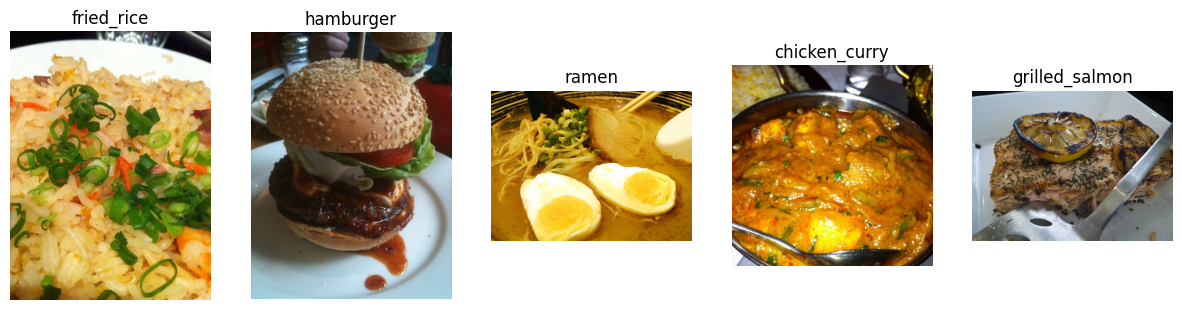

In [13]:
utils.plot_random_images(5, data_dir)

## 2. Experiment 0

- Ví dụ về `Feature extraction`, đóng băng toàn bộ base model, chỉ điều chỉnh đầu ra sao cho phù hợp với yêu cầu bài toán thực tế

In [14]:
from ml_helper import  model_builder

In [27]:
#@title Hyper parameters
pretrained_model_name = "efficientnetv2-b0" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']
batch_size = 32 #@param {type:"integer"}
do_fine_tuning = False #@param {type:"boolean"}
label_mode = "categorical" #@param ["binary", "categorical", "int"]
do_data_augmentation = True #@param {type:"boolean"}

image_size = model_builder.get_model_input_size(pretrained_model_name)

### Setup datasets

In [28]:
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"

train_datasets = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                     image_size=image_size,
                                                                     label_mode=label_mode,
                                                                     batch_size=batch_size)

test_datasets = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                    image_size=image_size,
                                                                    label_mode=label_mode)
                                                                     

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [29]:
class_names = train_datasets.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Build model

In [30]:
base_model = model_builder.get_base_model(pretrained_model_name, do_fine_tuning)
input_model = model_builder.create_input_layer(pretrained_model_name)

do_data_normalization = False if pretrained_model_name.startswith("efficientnet") else True

data_augmentation_layes = model_builder.create_preprocessing_layer(do_data_augmentation, do_data_normalization)

x = data_augmentation_layes(input_model)

if do_data_augmentation:
    x = base_model(x, training=False)
else:
    x = base_model(x)
    
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
output = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(input_model, output)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # sử dụng thuật tóa tối ưu Adam với learning rate cơ sở
              metrics=["accuracy"])

ValueError: Exception encountered when calling layer 'random_flip' (type RandomFlip).

Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

Call arguments received by layer 'random_flip' (type RandomFlip):
  • inputs=None
  • training=True